# Predicting JIA and Healthy Controls using XGBoost

In this notebook, we use the dataset [GSE81259](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81259) to predict JIA patients and healthy control participants.  The datasets includes 47 JIA (juvenile idiopathic arthritis) patients and 14 age-matched controls.  We apply XGBoost (eXtreme Gradient Boosting) with a train and test split to the data.

We then use SHAP (SHapley Additive exPlanations) to explain the predictions of the model.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in clinical data 
clin = pd.read_csv('data/GSE81259_clin_pub.csv', index_col = 0, header = 0)
clin.head()

,GEO GSM file ID,JIA_control,response_status
GEO ID,,,
JIA1,GSM2147667,JIA,RESP
JIA2,GSM2147668,JIA,NON-RESP
JIA3,GSM2147669,JIA,RESP
JIA4,GSM2147670,JIA,NON-RESP
JIA5,GSM2147671,JIA,RESP


In [3]:
# list of sample ids from column 'GEO GSM file ID' in clin
sample_ids = clin['GEO GSM file ID'].tolist()   
sample_ids[:5]

['GSM2147667', 'GSM2147668', 'GSM2147669', 'GSM2147670', 'GSM2147671']

In [4]:
# read in count data and select and order the columns according to the sample_ids
data = pd.read_csv('data/GSE81259_PBMCarray.csv', index_col = 0, header = 0)
data = data[sample_ids]
data = data.T
data.head()

REF_ID,A1BG,ADA,CDH2,AKT3,GAGE12F,ZBTB11-AS1,MED6,NAALAD2,SNORD116-4,SNORD116-17,...,RCE1,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,DGCR2,CASP8AP2,SCO2
GSM2147667,2.230262,4.287502,0.047112,2.696277,0.178127,2.051724,2.798878,0.760231,2.433349,1.033955,...,3.141504,6.467445,4.890767,3.708914,0.177147,4.533478,4.555939,4.378236,3.353766,5.962857
GSM2147668,2.076718,4.474807,0.231723,2.775313,0.121893,2.031543,2.775456,0.713071,2.116577,0.260178,...,3.388239,6.453457,4.831991,3.766517,0.327388,4.472643,4.387697,4.400673,3.347360,5.787106
GSM2147669,1.975005,4.881003,0.080278,2.271523,0.134423,1.872452,2.642762,0.663850,1.706486,0.635094,...,3.232520,6.553724,4.787105,3.757750,0.323556,4.288318,4.362412,4.238898,3.001191,6.422034
GSM2147670,2.405182,4.092159,0.025810,2.461102,0.135417,1.671465,2.617314,0.788595,2.034374,1.395815,...,3.540687,6.637830,4.761604,3.778179,0.091794,4.582637,4.560620,4.494842,2.919715,6.622172
GSM2147671,2.334368,4.323202,0.146190,2.483901,0.127919,1.782502,2.553282,0.757331,1.923689,0.951622,...,3.219133,6.628804,4.778759,3.841521,0.186310,4.439802,4.367744,4.398966,2.816094,6.542689


In [5]:
# in clin, create a new column for HC_Disease
# assign 1 to samples with 'JIA' in 'JIA_control' column and 0 to samples with 'control'
clin['HC_Disease'] = np.where(clin['JIA_control'] == 'JIA', 1, 0)
clin.head()

,GEO GSM file ID,JIA_control,response_status,HC_Disease
GEO ID,,,,
JIA1,GSM2147667,JIA,RESP,1
JIA2,GSM2147668,JIA,NON-RESP,1
JIA3,GSM2147669,JIA,RESP,1
JIA4,GSM2147670,JIA,NON-RESP,1
JIA5,GSM2147671,JIA,RESP,1


In [6]:
# shape of clin
print("clin shape", clin.shape)

# classes in HC_Disease
print(" ")
print("HC_Disease split:", np.bincount(clin['HC_Disease']))

clin shape (61, 4)
 
HC_Disease split: [14 47]


## PCA and t-SNE plots

In [7]:
# Scale the data for PCA and t-SNE
data_scaled = StandardScaler().fit_transform(data)

In [8]:
# Prepare the first 2 PCA components and plot
pca_2c = PCA(n_components = 2)
pca_2c_features = pca_2c.fit_transform(data_scaled)

pca_2c_df = pd.DataFrame(
    data = pca_2c_features, 
    columns = ['PC1', 'PC2'])

target = list(clin['HC_Disease'])

pca_2c_df['target'] = target

expl_var = round(sum(pca_2c.explained_variance_ratio_) * 100, 2)

pca1_expl_var = round(pca_2c.explained_variance_ratio_[0] * 100, 2)
pca2_expl_var = round(pca_2c.explained_variance_ratio_[1] * 100, 2)

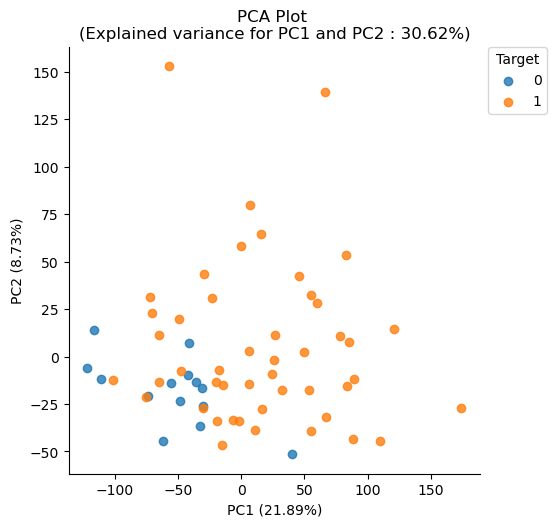

In [9]:
# Plot the first 2 PCA components
x_title = "PC1 (" + str(pca1_expl_var) + "%)"
y_title = "PC2 (" + str(pca2_expl_var) + "%)"

sub_title = "(Explained variance for PC1 and PC2 : " + str(expl_var) + "%)"
title = "PCA Plot \n" + sub_title

sns.lmplot(
    x = 'PC1', 
    y = 'PC2',
    data = pca_2c_df,
    hue = 'target',
    fit_reg = False,
    legend = False
)
plt.title(title)
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.xlabel(x_title)
plt.ylabel(y_title)
plt.show()

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


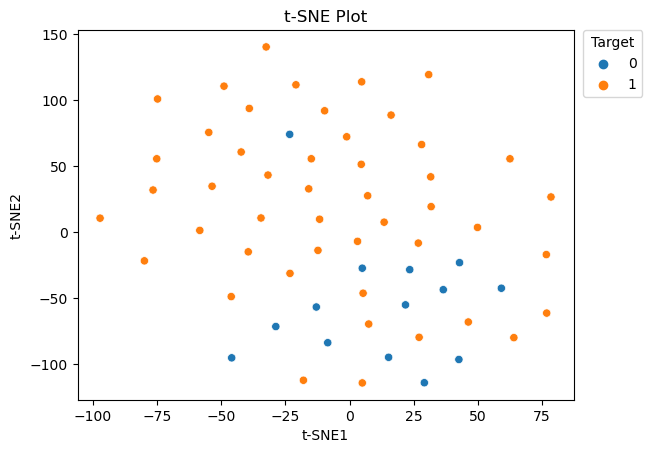

In [10]:
# t-SNE plot
tsne = TSNE(random_state=0)
tsne_results = tsne.fit_transform(data_scaled)
tsne_results = pd.DataFrame(tsne_results, columns = ['t-SNE1', 't-SNE2'])
tsne_results['target'] = target

sns.scatterplot(data = tsne_results, 
                x = "t-SNE1", 
                y = "t-SNE2",
                hue = 'target',
                legend = True
               )
plt.title('t-SNE Plot')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left', borderaxespad = 0, title = 'Target')
plt.show()

## Train and test the model

In [11]:
# Assign response, and split data for train and test
y =  clin["HC_Disease"]
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    stratify = y,
                                                    shuffle = True,
                                                    test_size = 0.25, 
                                                    random_state = 132)   
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (45, 18010)
X_test shape (16, 18010)


In [12]:
# Initiate and train the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 4,                       #  this has to be optimised for your model, range between 0->
         'eta': 0.5,                           #  this has to be optimised for your model, range between 0-1
         'objective': 'binary:logistic',       #  this depends on the nature of your model
        }

param['eval_metric'] = 'auc'                   #  this depends on the objective 
num_round = 100                                # number of rounds for boosting
evallist = [(dtest, 'eval'),(dtrain, 'train')] # eval test
progress = {}
model = xgb.train(param, dtrain, num_round, 
                     evals=evallist, evals_result = progress, 
                     verbose_eval=10, 
                     early_stopping_rounds=25) 

# classes in y_test
print(" ")
print("bincount y_test:", np.bincount(y_test))

[0]	eval-auc:0.85417	train-auc:0.99429
[10]	eval-auc:0.80208	train-auc:1.00000
[20]	eval-auc:0.80208	train-auc:1.00000
[25]	eval-auc:0.80208	train-auc:1.00000
 
bincount y_test: [ 4 12]


In [13]:
# Generate test predictions and assign to the nearest classification
preds = model.predict(dtest)
prediction =[]
for i in preds:
    if i >=0.5:
        prediction.append(1)
    else:
        prediction.append(0)
print("bincount prediction:", np.bincount(prediction))

bincount prediction: [ 4 12]


## Model performance

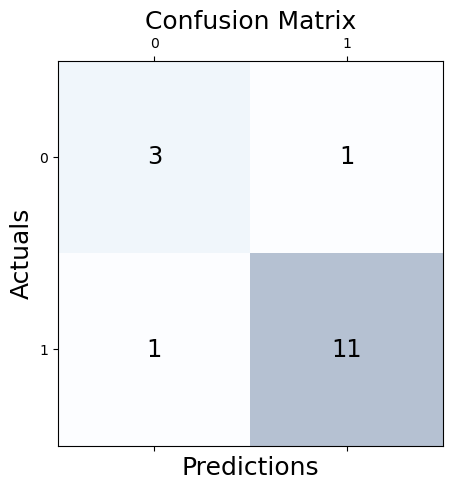

In [14]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [15]:
# Scores
print('Accuracy: %.3f' % accuracy_score(y_test, prediction))
print('F1 Score: %.3f' % f1_score(y_test, prediction))
print('Precision: %.3f' % precision_score(y_test, prediction))
print('Recall: %.3f' % recall_score(y_test, prediction))
print('ROC AUC: %.3f' % roc_auc_score(y_test, prediction))

Accuracy: 0.875
F1 Score: 0.917
Precision: 0.917
Recall: 0.917
ROC AUC: 0.833


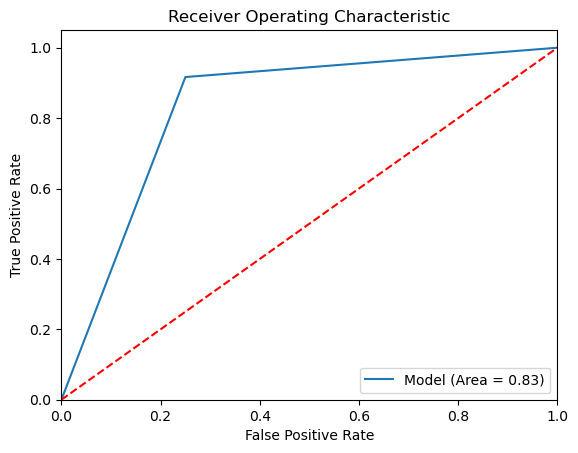

In [16]:
# ROC curve
y_true = np.array(y_test.values)
pred_array = np.array(prediction)
roc = roc_auc_score(y_true, pred_array)

fpr, tpr, thresholds = roc_curve(y_true, pred_array) 
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % roc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()


## SHAP summary plot

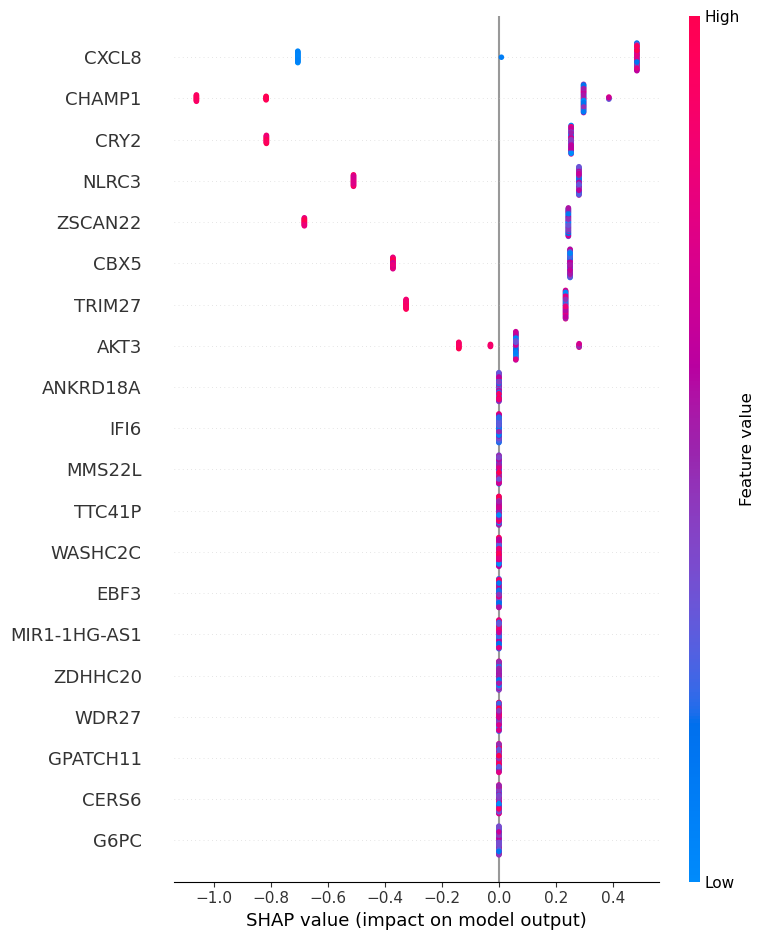

In [17]:
shap.initjs()

# Apply the generated model to the whole dataset and calculate the shap values
shap_values = shap.TreeExplainer(model).shap_values(data)  
explainer = shap.TreeExplainer(model, data)
expected_value = explainer.expected_value

features = data.columns

# Convert data DF to array
data_ = data.to_numpy()

# Run predictions for the whole dataset
d_data = xgb.DMatrix(data, label=y)

preds_data = model.predict(d_data)
prediction_data =[]
for i in preds_data:
    if i >=0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)

# Print the shap summary plot
shap.summary_plot(shap_values, data, feature_names=data.columns) 


## SHAP force plots

In [18]:
# A function that displays the actual value and the predicted value to the force plot
# Adapted from Max Steele def shap_force 
# https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

def shap_accuracy(prediction_list, index, y_values):
    pred = prediction_list[index]
    
    true_label = y_values[index]
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct'
    else:
        accurate = 'Incorrect'
        
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



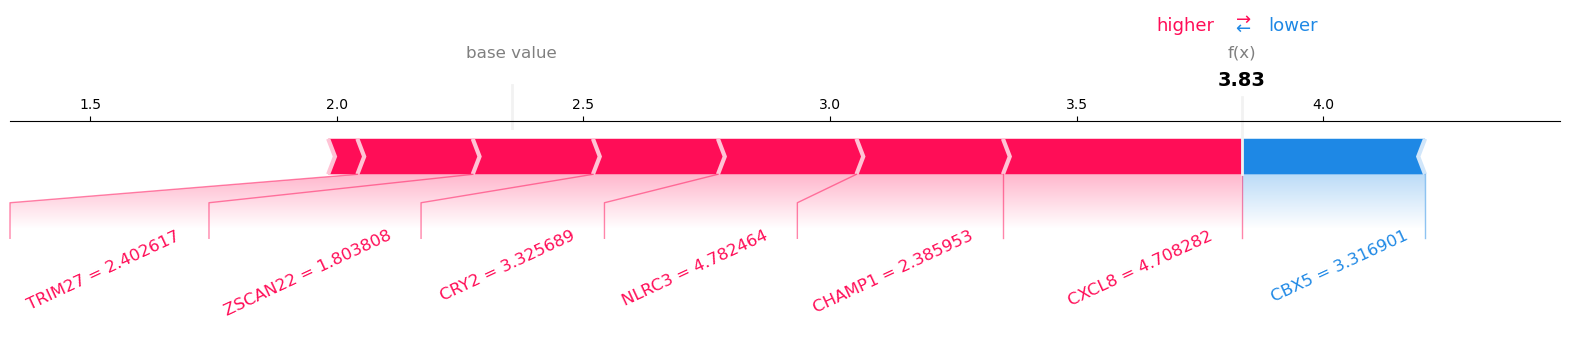

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



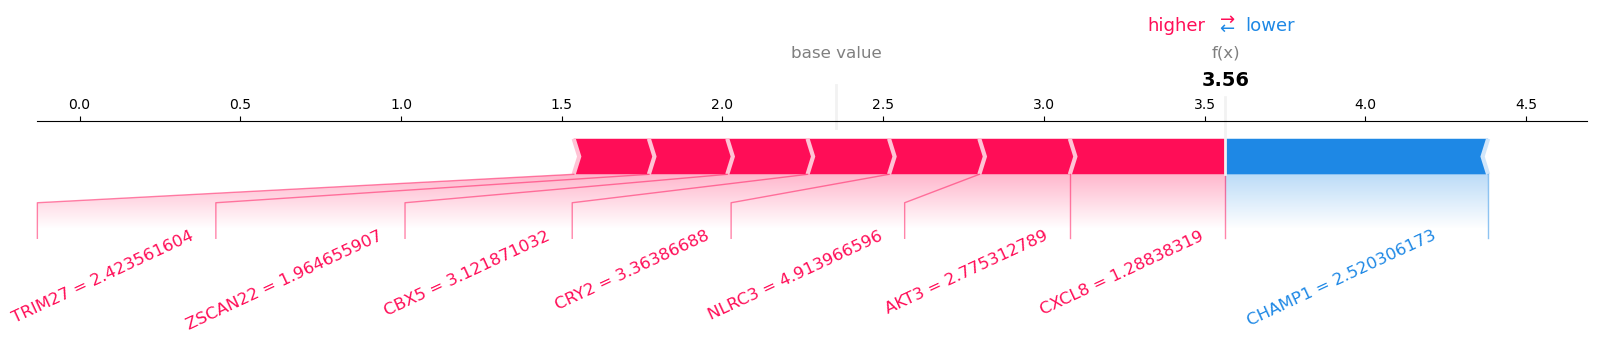

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



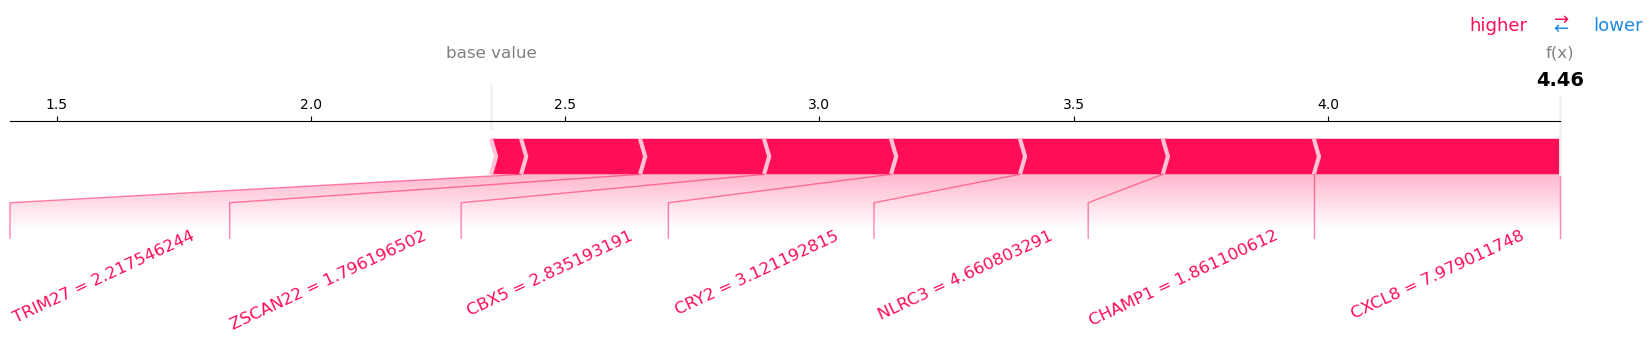

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



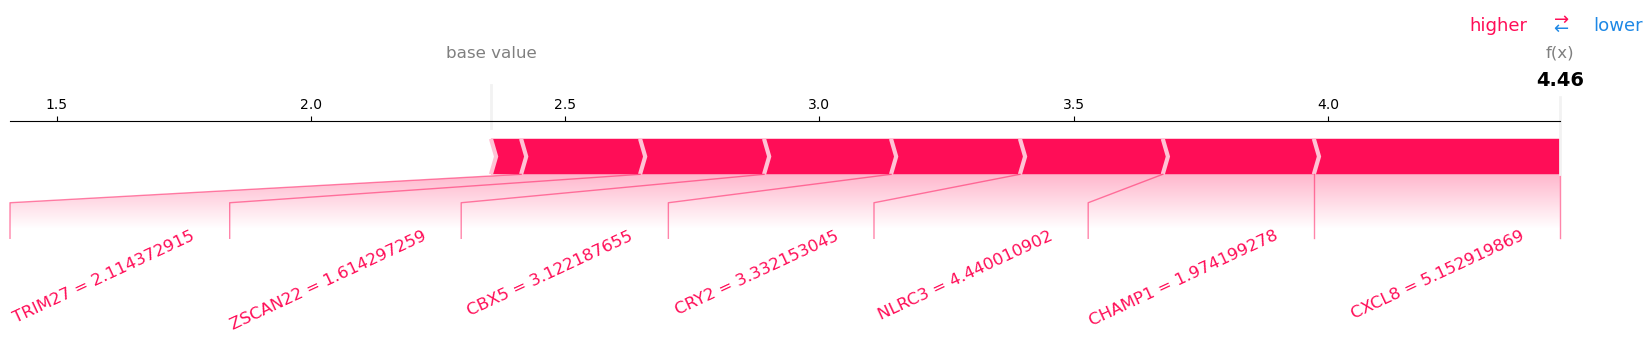

************************************
Ground Truth Label: 1
Model Prediction:  1 -- Correct
************************************



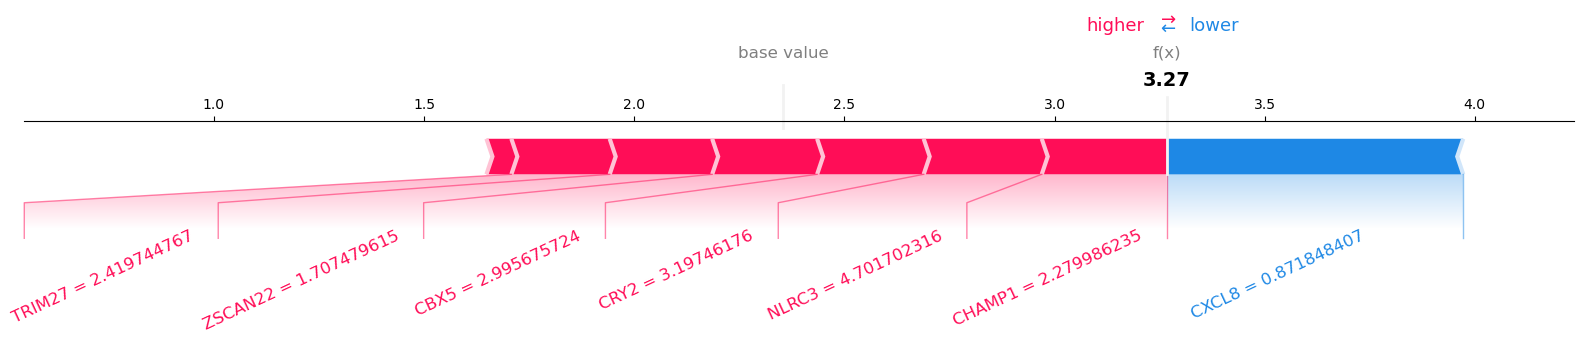

In [19]:
# display force plots for the first 5 samples

for i in range(5):
    shap_accuracy(prediction_data, i, y)
    shap.force_plot(expected_value, shap_values[i], data_[i], feature_names = features,
                matplotlib = True, plot_cmap="PkYg", text_rotation = 25)